#### Last Modified: Dec 29th, 2021 (Opal). 

# S-OpInf on Nonlinear Inviscid Burgers Equation


In [1]:
import os
os.chdir("../")
os.getcwd()

'/Users/oissan/PycharmProjects/Space-Weather-ROM'

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy import stats
import numpy as np 
import time
import astropy.units as u

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 


### General one-dimensional case
For a general one-dimensional nonlinear convection-dominated model, with a scalar state variable $u(x,t): [a,b] \times [0, T] \to \mathbb{R}^{+}$ with $k=1$, whose dynamics are described by the following quasi-linear partial differential equation

\begin{equation} \label{general-quasi-linear-pde}
    \frac{\partial u }{\partial t} + f(u) \frac{\partial u}{\partial x} = \frac{\partial}{\partial x} (D(x, t, u) \frac{\partial u}{\partial x})
\end{equation}

subject to the initial condition $u(x, t=0) = u_{0}(x)$ with appropriate boundary conditions at $x=a$ and $x=b$. The spatial shift leads to a change of independent variable, where $\tilde{x}(x, t) = x + c(t)$. The wave speed, $c(t)$, can be found in a purely data-driven approach based on cross-correlation or by the method of characteristics. By the chain rule, the dynamics in the moving coordinate frame $\tilde{u}(\tilde{x}(x, t), t) = u(x, t)$ are described by

\begin{equation} \label{general-quasi-linear-pde-shifted-dynamics}
    \frac{\partial \tilde{u}}{\partial t} + \left( f(\tilde{u}) + \frac{d c}{dt} \right ) \frac{\partial \tilde{u}}{\partial \tilde{x}} = \frac{\partial}{\partial \tilde{x}} \left (D(\tilde{x}, t, \tilde{u}) \frac{\partial \tilde{u}}{\partial \tilde{x}} \right )
\end{equation}

Given that the snapshots are spatially aligned in the moving coordinate frame, eliminating the translation properties present in $u(x, t)$, we are in the position to apply S-OpInf on $\tilde{u}(\tilde{x}, t)$.


### Shifted Operator Inference applied to the Invisicid Burgers Equation

The one-dimensional invisicid Burgers' equation is of the form of Eq above with $f(u) = u$ and $D(x, t, u) = 0$:

\begin{equation} \label{inviscid-burgers-equation}
    \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0
\end{equation}

subject to the initial condition $u(x, t=0)=u_{0}(x)$ with boundary conditions at $x=a$ and $x=b$. In the moving coordinate frame, $u(x, t) = \tilde{u} (x + c(t), t)$, Eq above becomes 

\begin{equation}\label{shifted-inviscid-burgers-equation}
\frac{\partial \tilde{u}}{\partial t} + \left(\tilde{u} + \frac{dc}{dt}\right) \frac{\partial \tilde{u}}{\partial \tilde{x}} = 0
\end{equation}

which can be written in conservative form as

\begin{equation}\label{shifted-burgers-conservative}
\frac{\partial \tilde{u}}{\partial t} +  \frac{\partial}{\partial \tilde{x}}\left[g(\tilde{u})\right] = 0
\end{equation}

with $g(\tilde{u}) = \frac{1}{2}\tilde{u}^2 + \frac{dc}{dt} \tilde{u}$. Then, by the conservative first-order upwind scheme, we approximate the derivative of the flux function $g$ with respect to $\tilde{x}$ by

\begin{equation} \label{conservative-upwind-scheme-burgers}
    \frac{\partial}{\partial \tilde{x}} [g(\tilde{u})] \approx \frac{1}{\Delta \tilde{x}}  \{g[\tilde{u}(\tilde{x}_{j+1}, t)] - g[\tilde{u}(\tilde{x}_{j}, t)]\}
\end{equation}

where $j$ denotes the grid index in $\tilde{x}$. In vector form, we can write the dynamics in quadratic form:

\begin{equation} \label{shifted-burgers-vector-form-quad}
\frac{d\mathbf{\tilde{u}}}{d t} = \mathbf{H} (\mathbf{\tilde{u}} \otimes \mathbf{\tilde{u}}) + \mathbf{A}(t) \mathbf{\tilde{u}}
\end{equation}

where $\otimes$ denotes the Kronecker product and  $\mathbf{\tilde{u}} = [\mathbf{\tilde{u}}(\tilde{x}_{1}, t), \mathbf{\tilde{u}}(\tilde{x}_{2}, t), ..., \mathbf{\tilde{u}}(\tilde{x}_{n}, t)]^{\top} \in \mathbb{R}^{n}$ is the state vector discretized over $n$ spatial points at time $t$. The operator $\mathbf{A}(t) \in \mathbb{R}^{n \times n}$ is the linear operator and $\mathbf{H} \in \mathbb{R}^{n \times n^2}$ is the quadratic operator. If $c(t)$ is linear, meaning the wave is traveling in constant speed, then the linear operator $\mathbf{A}(t) = \mathbf{A}$ does not depend on time. Given the FOM is in polynomial form, Operator Inference can maintain the same polynomial structure in the  low-dimensional basis with high accuracy.


### Set Grid Size

In [4]:
# number of mesh points in the T axis. 
m = 1000
# number of mesh points in X axis. 
n = 500
# final time. 
T = 2
# boundary of x 
a = 0
b = 3
# flux function
def f_fun(u):
    return u

def F_fun(u): 
    return 0.5*(u**2)

def D_fun(u, x, t): 
    return 0

def a_fun(u1, u2):
    if np.abs(u1 - u2) > 1e-16:
        return (F_fun(u2) - F_fun(u1))/(u2 - u1)
        
    else:
        return f_fun(u1)

In [5]:
t_vec = np.linspace(0, T, m)
x_vec = np.linspace(a, b, n)

In [6]:
initial_condition = 0.8 +  0.5*np.exp(-(x_vec - 1)**2/(0.1))

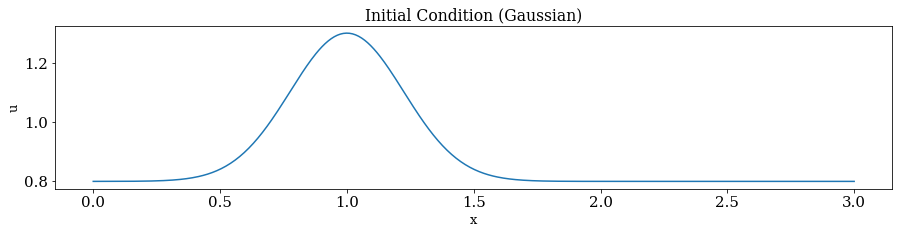

In [7]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(x_vec, initial_condition)
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("u")
_ = ax.set_title("Initial Condition (Gaussian)")

In [8]:
def solve_upwind_scheme(initial_condition, t_vec, x_vec):
    """ solve a 1-d advection diffusion equation using the first order conservative upwind scheme"""
    U = np.zeros((len(x_vec), len(t_vec)))
    
    U[:, 0] = initial_condition
    
    dt = np.mean(t_vec[1:] - t_vec[:-1])
    dx = np.mean(x_vec[1:] - x_vec[:-1])
    
    for ii in range(len(t_vec) -1):
        for jj in range(len(x_vec)):
            if (U[jj, ii] * dt/dx) > 1:
                print("cfl violated. ")
                
            # force periodicity 
            if jj == len(x_vec) - 1:
                # F_{j+1/2}^{n}
                a1 = a_fun(U[jj, ii], U[0, ii])            
                F1 = (F_fun(U[0, ii]) + F_fun(U[jj, ii]))/2 - np.abs(a1)*(U[0, ii] - U[jj, ii])/2

            else:
                # F_{j+1/2}^{n}
                a1 = a_fun(U[jj, ii], U[jj + 1, ii])            
                F1 = (F_fun(U[jj + 1, ii]) + F_fun(U[jj, ii]))/2 - np.abs(a1)*(U[jj+1, ii] - U[jj, ii])/2

            # F_{j-1/2}^{n}
            a2 = a_fun(U[jj - 1, ii], U[jj, ii])
            F2 = (F_fun(U[jj, ii]) + F_fun(U[jj -1, ii]))/2 - np.abs(a2)*(U[jj, ii] - U[jj -1, ii])/2

            # update the next cell.
            U[jj, ii+1] = U[jj, ii] - (dt/dx)*(F1 - F2)
    return U

In [9]:
U_sol = solve_upwind_scheme(initial_condition, t_vec, x_vec)

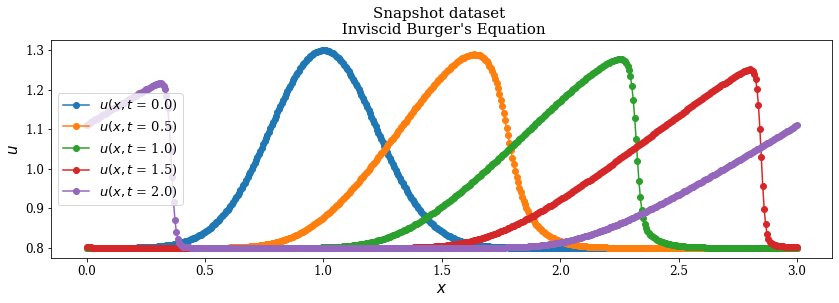

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.linspace(0, len(t_vec) -1, 5):
    ax.plot(x_vec, U_sol[:, int(ii)], "-o", label="$u(x, t$ = "+ str(round(t_vec[int(ii)], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Snapshot dataset \n Inviscid Burger's Equation", fontsize=15)
_ = ax.legend()

# Compute the spatial shift function $c(t)$

In [11]:
def compute_spatial_shift(x_vec, t_vec, U, method=None):
    # initialize shift matrix. 
    shift_mat = np.zeros((len(x_vec), len(t_vec)))
    
    # phi at index 0 is original grid 
    shift_mat[:, 0] = np.zeros(len(x_vec))
    
    # delta t.
    dt = t_vec[1:] - t_vec[:-1]
    
    # compute the shift for each idx in t. 
    for ii in range(len(t_vec)-1):
        if method == "ballistic":
            shift = U[:, 0] * dt[ii]
        else:
            shift = U[:, ii]*dt[ii]
        shift_mat[:, ii+1] = shift_mat[:, ii] + shift
        
    return shift_mat

In [12]:
shift_mat = compute_spatial_shift(x_vec, t_vec, U_sol, method="ballistic")

# Shifted Coordinates

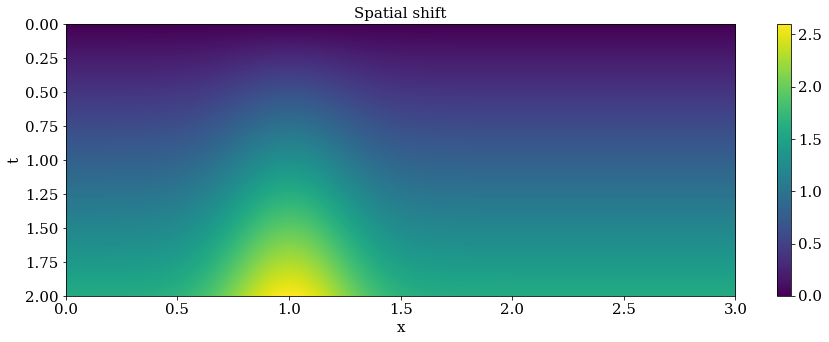

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
pos = ax.imshow(shift_mat.T, extent=[x_vec[0],x_vec[-1],t_vec[-1], t_vec[0]], aspect="auto")
cbar = fig.colorbar(pos, ax=ax)
#cbar.ax.set_ylabel('', rotation=90, fontsize=15)
_ = ax.set_xlabel(r"x", fontsize=15)
_ = ax.set_ylabel(r"t", fontsize=15)
_ = ax.set_title("Spatial shift", fontsize=15)

In [14]:
index_b = 100#350
index_e = 300#500
x_vec[index_e]

1.8036072144288577

In [15]:
print("x-begin", x_vec[index_b])
print("x-end", x_vec[index_e])

x-begin 0.6012024048096193
x-end 1.8036072144288577


In [16]:
c_r_vec = [0]

In [17]:
U_new = np.zeros(U_sol.shape)
U_new[:, 0] = U_sol[:, 0]
for ii in range(1, len(t_vec)):
    avg_shift = np.mean(shift_mat[index_b:index_e, ii]) #+ np.std(shift_mat[:, ii])
    c_r_vec.append(avg_shift)
    f_interp = interp1d(x_vec, U_sol[:, ii], fill_value="extrapolate")
    x_new = (x_vec + avg_shift) % (b)
    U_new[:, ii] = f_interp(x_new)

In [18]:
np.mean(shift_mat[index_b:index_e, 1])

0.002051259255041131

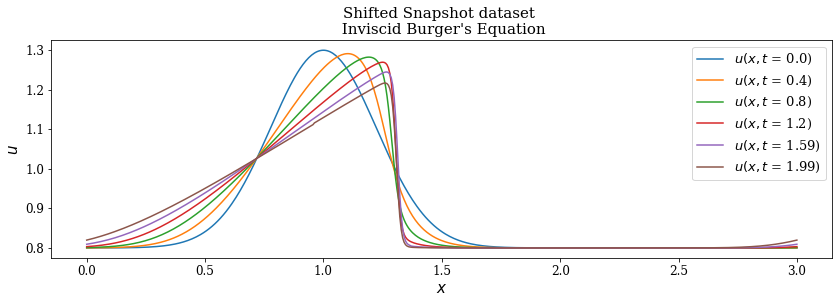

In [19]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, U_new[:, ii], "-", label="$u(x, t$ = "+ str(round(t_vec[ii], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Shifted Snapshot dataset \n Inviscid Burger's Equation", fontsize=15)
_ = ax.legend()

# Cross-Correlation method 

In [20]:
def periodic_corr_np(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return np.correlate(x, np.hstack((y[1:], y)), mode='valid')

def normalize(x):
    return (x - np.mean(x))/np.std(x)

In [21]:
v1 = U_sol[:, 0]
shift_vec = [0, 0]

for ii in range(2, len(t_vec)):
    v2 = U_sol[:, ii]
    corr = periodic_corr_np(normalize(v1), normalize(v2))
    corr = corr/np.max(corr)
    shift_vec.append(b-x_vec[np.argmax(corr)])

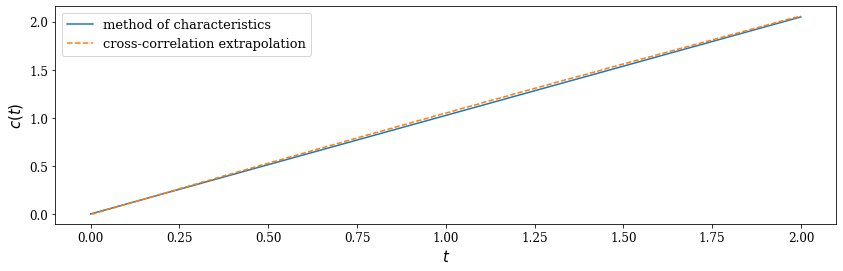

In [22]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(t_vec, np.array(c_r_vec), "-", label="method of characteristics")
ax.plot(t_vec[1:], shift_vec[1:], "--", label="cross-correlation extrapolation")
_ = ax.set_xlabel("$t$", fontsize=15)
_ = ax.set_ylabel("$c(t)$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
#_ = ax.set_title("shift as function of time", fontsize=15)
_ = ax.legend()

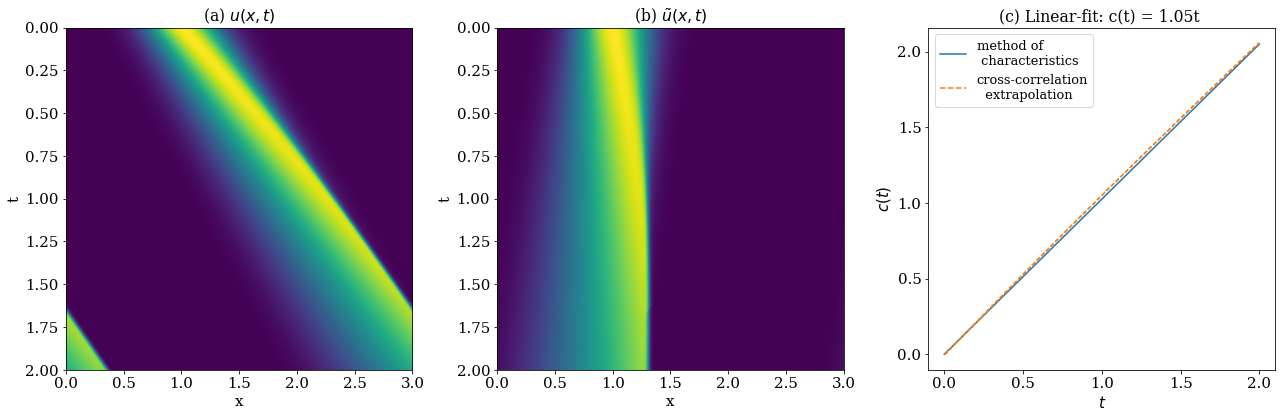

In [23]:
fig, ax = plt.subplots(ncols=3, nrows=1,figsize=(18, 6))
ax[0].imshow(U_sol.T, extent=[a,b, T, 0], aspect="auto")
ax[1].imshow(U_new.T, extent=[a,b, T, 0],  aspect="auto")

ax[0].set_xlabel("x", fontsize=15)
ax[1].set_xlabel("x", fontsize=15)
ax[0].set_ylabel("t", fontsize=15)
ax[1].set_ylabel("t", fontsize=15)
ax[0].set_title(r"(a) $u(x, t)$")
ax[1].set_title(r"(b) $\tilde{u}(x, t)$")

n = int(len(t_vec)*0.7)
m_slope, b_slope = np.polyfit(t_vec[:n], np.array(shift_vec[:n]), 1)
ax[2].set_title("(c) Linear-fit: c(t) = " + str(round(m_slope, 2)) + "t " )#+ str(round(b_slope, 2)))


ax[2].plot(t_vec, np.array(c_r_vec), "-", label="method of \n characteristics")
ax[2].plot(t_vec, np.array(shift_vec), "--", label="cross-correlation\n  extrapolation")
_ = ax[2].set_xlabel("$t$", fontsize=15)
_ = ax[2].set_ylabel("$c(t)$", fontsize=15)
ax[2].legend()

plt.tight_layout()

plt.savefig("Burgers/figs/burgers_eqn_comparison_of_methods_to_compute_shift.png", dpi=500)

# Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [24]:
# set up the first l indexes used for training. 
l = int(0.8*(len(t_vec)))

In [25]:
X= U_new

In [26]:
X_train = X[:, :l]
X_test = X[:, l:-1]

In [27]:
t_train = t_vec[:l]
t_test = t_vec[l:-1]

In [28]:
print("U train shape", np.shape(X_train))
print("Time Interval train: " + str(t_vec[0]) + " to " + str(t_vec[l]))
print("\nU test shape", np.shape(X_test))
print("Time Interval test: " + str(t_vec[l]) + " to " + str(t_vec[-1]))

U train shape (500, 800)
Time Interval train: 0.0 to 1.6016016016016015

U test shape (500, 199)
Time Interval test: 1.6016016016016015 to 2.0


## Using the ROM Operator Inference Package


### Step 1: Choosing the Reduced-model Dimension
There are several ways to choose $r$ in an informed way.
A simple choice is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [29]:
svdvals = la.svdvals(X_train)
svdvals_prev = la.svdvals(U_sol[:, :l])

In [30]:
# Calculate the cumulative energy.
thresh = .99999
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 24
r (Eularian coordinates)= 110


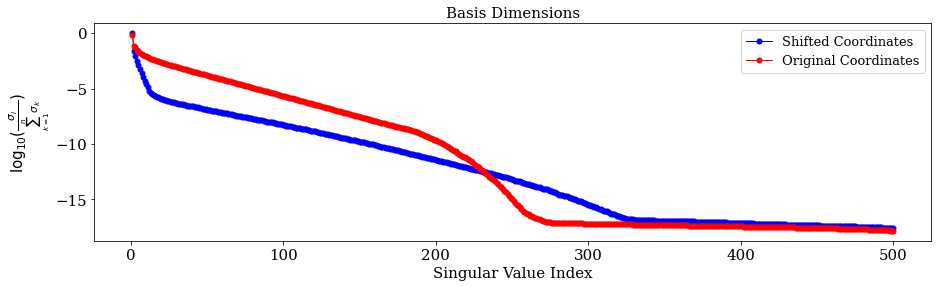

In [31]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
#plot singluar values cumulative energy
ax.plot(np.arange(1, len(svdvals)+1), np.log10(svdvals/ np.sum(svdvals)), '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, len(svdvals_prev) +1), np.log10(svdvals_prev/ np.sum(svdvals_prev)), '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")


plt.legend()
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"$\log_{10}(\frac{\sigma_{i}}{\sum_{k=1}^{n} \sigma_{k}})$", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)

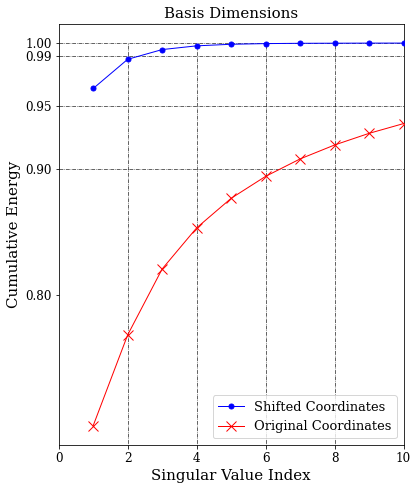

In [32]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(6, 7))

xlim= 10

# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, svdvals.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
# get current y-limits 
ylim = ax.get_ylim()
# plot vertical and horizontal lines based on threshhold value
#ax.vlines(rank, 0, thresh, color="blue", linewidth=.6, linestyle="-.")
#ax.vlines(rank_prev, 0, thresh, color="red", linewidth=.6, linestyle="-.")


# set up axis. 
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")

ax.vlines(2, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(4, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(6, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(8, 0, 1, color="black", linewidth=.6, linestyle="-.")

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()     
plt.savefig("figs/singular_value_decay_burgers.png", pad_inches=1)

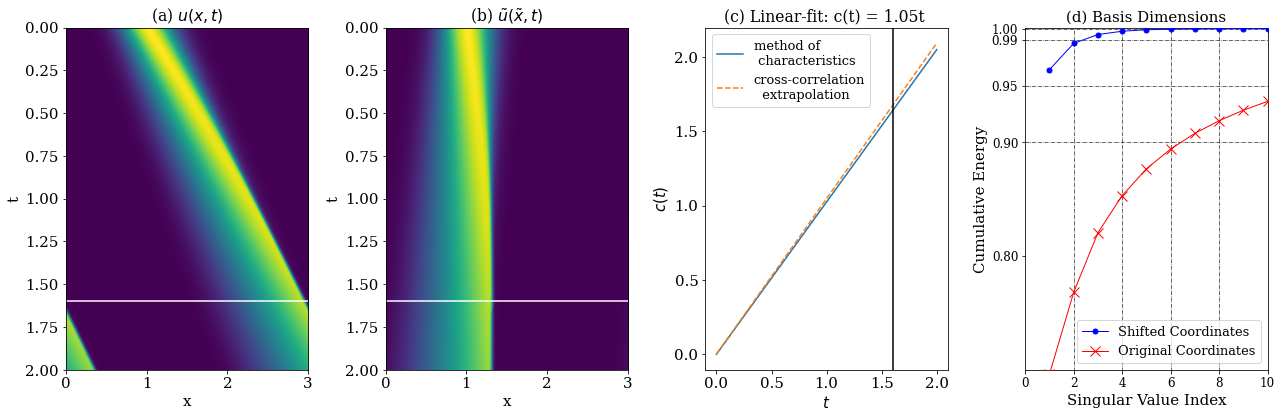

In [33]:
fig, ax = plt.subplots(ncols=4, nrows=1,figsize=(18, 6))
ax[0].imshow(U_sol.T, extent=[a,b, T, 0], aspect="auto")
ax[1].imshow(U_new.T, extent=[a,b, T, 0],  aspect="auto")

ax[0].set_xlabel("x", fontsize=15)
ax[1].set_xlabel("x", fontsize=15)
ax[0].set_ylabel("t", fontsize=15)
ax[1].set_ylabel("t", fontsize=15)
ax[0].set_title(r"(a) $u(x, t)$")
ax[1].set_title(r"(b) $\tilde{u}(\tilde{x}, t)$")

ax[0].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
ax[1].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")

n = int(len(t_vec)*0.7)
m_slope, b_slope = np.polyfit(t_vec[:n], np.array(shift_vec[:n]), 1)
ax[2].set_title("(c) Linear-fit: c(t) = " + str(round(m_slope, 2)) + "t " )#+ str(round(b_slope, 2)))


ax[2].plot(t_vec, np.array(c_r_vec), "-", label="method of \n characteristics")
ax[2].plot(t_vec, t_vec*m_slope + b_slope, "--", label="cross-correlation\n  extrapolation")
_ = ax[2].set_xlabel("$t$", fontsize=15)
_ = ax[2].set_ylabel("$c(t)$", fontsize=15)
ax[2].axvline(t_train[-1], color="black")
ax[2].legend()


# plot singluar values cumulative energy
ax[3].plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax[3].plot(np.arange(1, svdvals.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
# get current y-limits 
ylim = ax[3].get_ylim()

# set up axis. 
ax[3].hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[3].hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[3].hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[3].hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")

ax[3].vlines(2, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax[3].vlines(4, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax[3].vlines(6, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax[3].vlines(8, 0, 1, color="black", linewidth=.6, linestyle="-.")


plt.legend()

_ = ax[3].set_xlim(0, xlim)
_ = ax[3].set_ylim(bottom=0.7, top=1.001)
_ = ax[3].set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax[3].set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax[3].set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax[3].set_title("(d) Basis Dimensions", fontsize=15)
_ = ax[3].tick_params(axis='both', which='major', labelsize=12)


plt.tight_layout()

plt.savefig("Burgers/figs/burgers_eqn_comparison_of_methods_to_compute_shift.png", dpi=500)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [34]:
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (500, 24)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

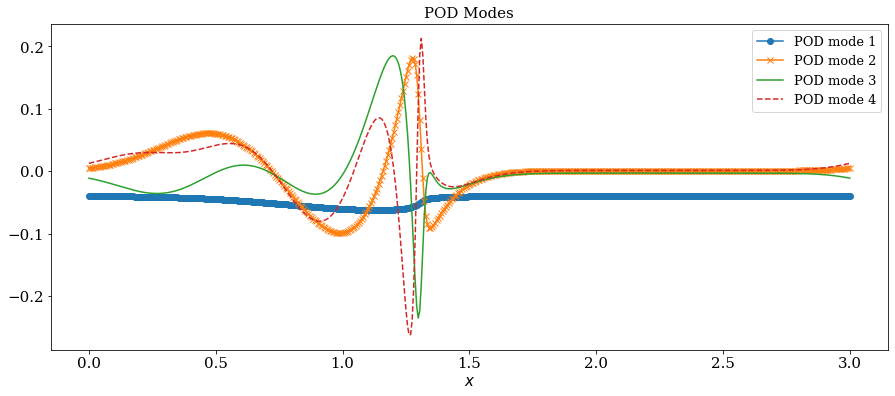

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(x_vec, Vr[:,0], "-o", label=f"POD mode {1}")
ax.plot(x_vec, Vr[:,1], "-x", label=f"POD mode {2}")
ax.plot(x_vec, Vr[:,2], "-", label=f"POD mode {3}")
ax.plot(x_vec, Vr[:,3], "--", label=f"POD mode {4}")
#ax.plot((180/np.pi) * p_new, Vr[:len(p_new),4], "-", label=f"POD mode {5}")

ax.set_xlabel("$x$", fontsize=15)
ax.set_title("POD Modes", fontsize=15)
plt.legend(loc="upper right")
plt.show()

In [36]:
roi.pre.projection_error(X_train, Vr)

2.0175690391087073e-06

In [37]:
def convert_from_x_to_v(X_ROM):
    V_ROM = np.zeros(X_ROM.shape)
    V_ROM[:, 0] = X_ROM[:, 0]
    phi_shift_rom = compute_spatial_shift(x_vec, t_vec, X_ROM)
    for jj in range(1, len(t_vec)):
        avg_shift = np.mean(phi_shift_rom[index_b:index_e, jj]) #+ np.std(shift_mat[jj, :])
        f_interp = interp1d(x_vec, X_ROM[:, jj], fill_value="extrapolate")
        x_new = (x_vec - avg_shift) % (x_vec[-1])
        V_ROM[:, jj] = f_interp(x_new)
    return V_ROM

In [38]:
def regularizer(r, λ1, λ2, λ3=None):
    """Return the regularizer that penalizes all operator elements by λ1,
    except for the quadratic operator elements, which are penalized by λ2.
    If λ3 is given, the entries of the cubic operator are penalized by λ3.
    Parameters
    ----------
    r : int
        Dimension of the ROM.
    λ1 : float
        Regularization hyperparameter for the non-quadratic operators.
    λ2 : float
        Regularization hyperparameter for the quadratic operator.
    λ2 : float or None
        Regularization hyperparameter for the cubic operator (if present).
    Returns
    -------
    diag(𝚪) : (d,) ndarray
        Diagonal entries of the dxd regularizer 𝚪.
    """
    r1 = 1 + r
    r2 = r + r*(r + 1)//2
    if λ3 is None:
        diag𝚪 = np.full(r2, λ1)
        diag𝚪[r1:-1] = λ2
    else:
        r3 = r2 + r*(r + 1)*(r + 2)//6
        diag𝚪 = np.full(r3+1, λ1)
        diag𝚪[r1:r2] = λ2
        diag𝚪[r2:-1] = λ3
    return diag𝚪

# Quadratic-Linear ROM $\dot{\hat x} = \hat{A} \hat{x} + \hat{H} (\hat{x} \otimes \hat{x})$

In [80]:
rank=13
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
Xdot = roi.pre.xdot(X_train, t_vec[1]-t_vec[0], order=6)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="AH")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=regularizer(rank, 1e3, 1e1))                          # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.

In [81]:
V_ROM = convert_from_x_to_v(X_ROM)

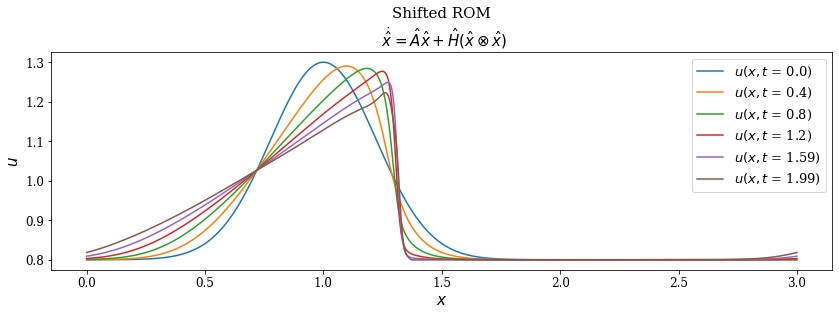

In [82]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, X_ROM[:, ii], label="$u(x, t$ = "+ str(round(t_vec[ii], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Shifted ROM\n $\dot{\hat x} = \hat{A} \hat{x} + \hat{H} (\hat{x} \otimes \hat{x})$", fontsize=15)
_ = ax.legend()

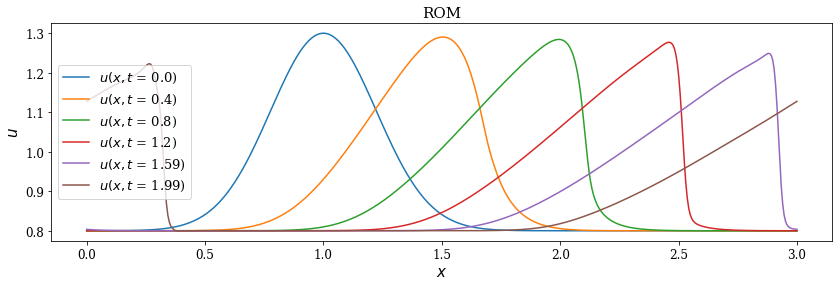

In [83]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, V_ROM[:, ii], label="$u(x, t$ = "+ str(round(t_vec[ii], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("ROM", fontsize=15)
_ = ax.legend()

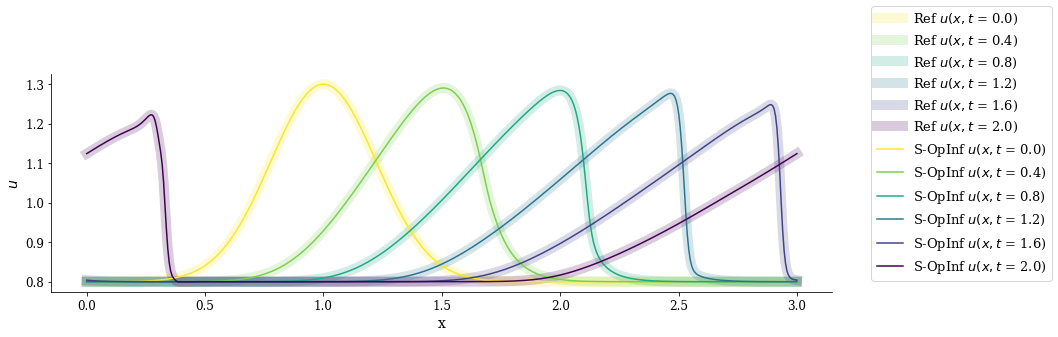

In [88]:
sample_columns = np.arange(0, len(t_vec), int(len(t_vec)//5))
sample_columns = np.append(sample_columns, len(t_vec) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(x_vec, V_ROM[:, j], color=curr_color, linewidth=10.0, alpha=0.2,  label="Ref $u(x, t$ = "+ str(round(t_vec[j], 2)) + ")")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    ax.plot(x_vec, V_ROM[:, j],color=curr_color,  label="S-OpInf $u(x, t$ = "+ str(round(t_vec[j], 2)) + ")")

ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("$u$", fontsize=14)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig("Burgers/figs/shifted_opinf_results_burgers.png", dpi=500, bbox_inches='tight')

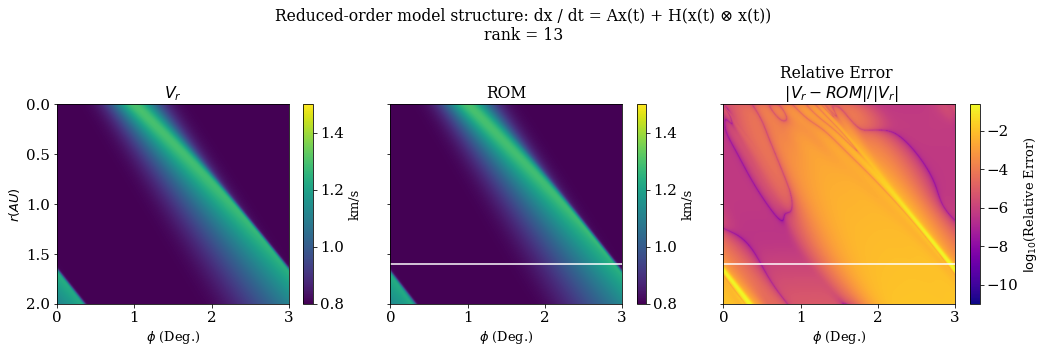

In [85]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(U_sol.T, extent=[a, b,T, 0], vmax=0.8, vmin=1.5, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r (AU)$")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[a,b,T, 0], vmax=0.8, vmin=1.5, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("ROM")
ax[1].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.log10(np.abs(V_ROM.T - U_sol.T)/np.abs(U_sol).T), extent=[a,b,T, 0], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])

cbar.ax.set_ylabel('$\log_{10}$(Relative Error)', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

In [86]:
print("mean relative error = ", np.mean(np.abs((U_sol.T - V_ROM.T))/np.abs(U_sol.T)))

mean relative error =  0.0033731393743999974


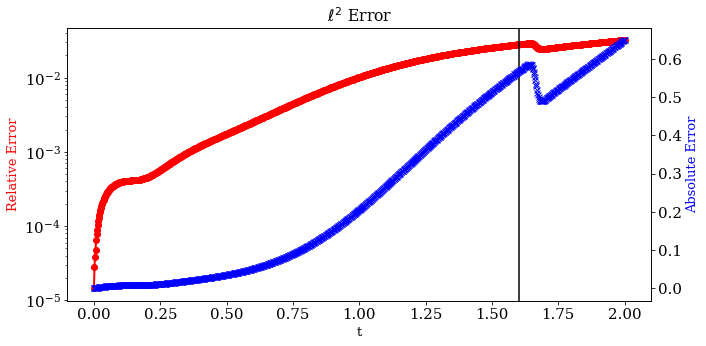

In [87]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err, rel_l2err = roi.post.lp_error(U_sol, V_ROM, p=2)
_ = ax.plot(t_vec, rel_l2err,"-o", linewidth=2, c="r")
_ = ax.axvline(t_vec[l], c="k")
_ = ax.set_title(r"$\ell^2$ Error")
_ = plt.yscale("log")
_ = ax.set_ylabel("Relative Error", c="r")
_ = ax.set_xlabel("t")

ax2=ax.twinx()
_ = ax2.plot(t_vec, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Absolute Error", c="b")

plt.tight_layout()

# Optimize free parameters $\lambda_{1}, \lambda_{2}, r$

In [75]:
coeff1_array = 10**np.linspace(1, 5, 10)
coeff2_array = 10**np.linspace(1, 5, 10)
rank_array = np.arange(5, 15, 1)

training_error = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array))) * np.inf
testing_error = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array))) * np.inf

In [76]:
for kk, coeff1 in enumerate(coeff1_array):
    for jj, coeff2 in enumerate(coeff2_array):
        for ii, rank_r in enumerate(rank_array):
            Vr, _ = roi.pre.pod_basis(X_train, r=rank_r) 
            Xdot = roi.pre.xdot(X_train, (t_vec[1] - t_vec[0]), order=6)           
            model = roi.InferredContinuousROM(modelform="AH")              
            model.fit(Vr, X_train, Xdot, P=regularizer(rank_r, coeff1, coeff2))  
            X_ROM = model.predict(X[:, 0], t_vec, method="BDF") 

            if np.shape(X_ROM) == np.shape(X):
                V_ROM = convert_from_x_to_v(X_ROM)
                # save
                training_error[kk, jj, ii] = np.log10(roi.post.frobenius_error(U_sol[:, :l], V_ROM[:, :l])[1])
                # save
                testing_error[kk, jj, ii] = np.log10(roi.post.frobenius_error(U_sol[:, l:], V_ROM[:, l:])[1])

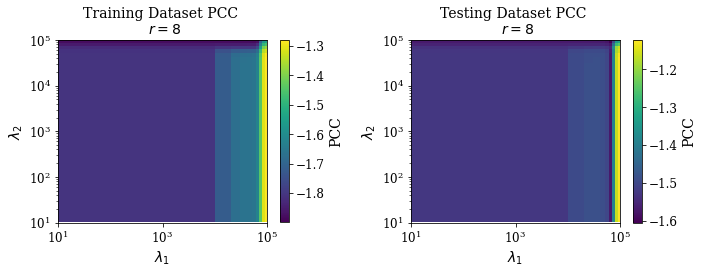

In [77]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

pos1 = ax[0].imshow(training_error[:, :, 0].T, extent=[coeff1_array[0], coeff1_array[-1], 
                                          coeff2_array[0], coeff2_array[-1]],  aspect="auto")


_ = ax[0].set_xlabel(r"$\lambda_{1}$", fontsize=14)
_ = ax[0].set_ylabel(r"$\lambda_{2}$", fontsize=14)
_ = ax[0].set_title("Training Dataset PCC \n $r = 8$", fontsize=14)
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(pos1, ax=ax[0])
cbar.ax.set_ylabel('PCC', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

pos2 = ax[1].imshow(testing_error[:, :, 0].T, extent=[coeff1_array[0], coeff1_array[-1], 
                                          coeff2_array[0], coeff2_array[-1]],  aspect="auto")


_ = ax[1].set_xlabel(r"$\lambda_{1}$", fontsize=14)
_ = ax[1].set_ylabel(r"$\lambda_{2}$", fontsize=14)
_ = ax[1].set_title("Testing Dataset PCC \n $r = 8$", fontsize=14)
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
cbar = fig.colorbar(pos2, ax=ax[1])
cbar.ax.set_ylabel('PCC', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax[1].set_xscale("log")
ax[0].set_xscale("log")
ax[1].set_yscale("log")
ax[0].set_yscale("log")

plt.tight_layout()

In [78]:
idx  = np.unravel_index(training_error[:, :, :].argmin(), training_error[:, :, :].shape)
print("Training lambda1 =",  np.log10(coeff1_array[idx[0]]))
print("Training lambda2 =",  np.log10(coeff2_array[idx[1]]))
print("Training rank =",  rank_array[idx[2]])

Training lambda1 = 3.6666666666666665
Training lambda2 = 1.0
Training rank = 13


In [79]:
idx  = np.unravel_index(testing_error[:, :, :].argmin(), testing_error[:, :, :].shape)
print("Testing lambda1 =",  np.log10(coeff1_array[idx[0]]))
print("Testing lambda2 =",  np.log10(coeff2_array[idx[1]]))
print("Testing rank =",  rank_array[idx[2]])

Testing lambda1 = 3.6666666666666665
Testing lambda2 = 1.0
Testing rank = 13


# Sensitivity to Training Data

* **Test 1**: 120 training snapshots. 

* **Test 2**: 150 training snapshots. 

* **Test 3**: 180 training snapshots.

In [74]:
# initialize the training length. 
l1, l2, l3 = 300, 400, 500


X_train1 = X[:, :l1]
X_test1 = X[:, l1:-1]


X_train2 = X[:, :l2]
X_test2 = X[:, l2:-1]


X_train3 = X[:, :l3]
X_test3 = X[:, l3:-1]

In [75]:
r_train1 = t_vec[:l1]
r_test1 = t_vec[l1:-1]

r_train2 = t_vec[:l2]
r_test2 = t_vec[l2:-1]

r_train3 = t_vec[:l3]
r_test3 = t_vec[l3:-1]

In [76]:
# l1 = compute the results for quadradic with 3 modes.
rank=8
Vr, _ = roi.pre.pod_basis(X_train1, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train1, t_vec[1] - t_vec[0], order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="AH")              # Define the model structure.
model.fit(Vr, X_train1, Xdot, P=1E4)                          # Construct the ROM with Operator Inference.
X_ROM1 = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
V_ROM1 = convert_from_x_to_v(X_ROM1)

# l2 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train2, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train2, t_vec[1] - t_vec[0], order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="AH")              # Define the model structure.
model.fit(Vr, X_train2, Xdot, P=1E4)                          # Construct the ROM with Operator Inference.
X_ROM2 = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
V_ROM2 = convert_from_x_to_v(X_ROM2)

# l3 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train3, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train3, t_vec[1] - t_vec[0], order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="AH")              # Define the model structure.
model.fit(Vr, X_train3, Xdot, P=1E4)                          # Construct the ROM with Operator Inference.
X_ROM3 = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
V_ROM3 = convert_from_x_to_v(X_ROM3)

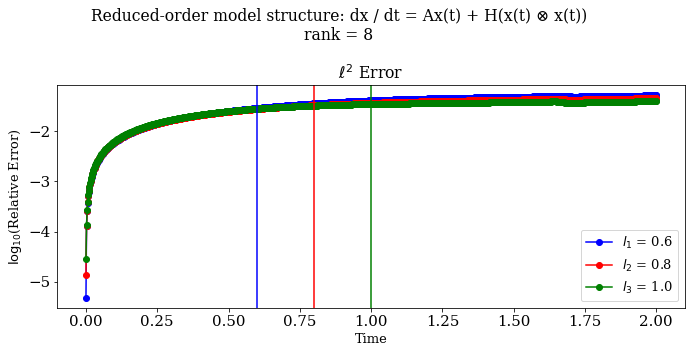

In [77]:
fig, ax = plt.subplots(figsize=(10, 5))
# l1
abs_l2err1, rel_l2err1 = roi.post.lp_error(U_sol, V_ROM1)
_ = ax.plot(t_vec, np.log10(rel_l2err1), "-o", c="b", label="$l_{1}$ = " + str(round(t_vec[l1], 2)))

#l2
abs_l2err2, rel_l2err2 = roi.post.lp_error(U_sol, V_ROM2)
_ = ax.plot(t_vec, np.log10(rel_l2err2), "-o", c="r", label="$l_{2}$ = " + str(round(t_vec[l2], 2)))

#l3
abs_l2err3, rel_l2err3 = roi.post.lp_error(U_sol, V_ROM3)
_ = ax.plot(t_vec, np.log10(rel_l2err3), "-o", c="g", label="$l_{3}$ = " + str(round(t_vec[l3], 2)))

_ = ax.axvline(r_train1[-1], c="b")
_ = ax.axvline(r_train2[-1], c="r")
_ = ax.axvline(r_train3[-1], c="g")
_ = ax.set_title(r"$\ell^2$ Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)")
_ = ax.set_xlabel("Time")

plt.legend()
plt.suptitle(str(model) + "\n" + "rank = " + str(rank))
plt.tight_layout()